# Modelling Games with Tensoflow Probability


### Imports

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors

print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

np.random.seed(42)
tf.random.set_seed(42)

2022-06-08 17:07:39.044367: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-08 17:07:39.044388: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TFP Version 0.16.0
TF  Version 2.9.1


### Loading data

In [8]:
df = pd.read_csv('/home/pf/Documents/FPL/data/fivethirtyeight/spi_matches.csv')
df = df.loc[(df['league_id'] == 2411) | (df['league_id'] == 2412)]
df = df.dropna()
teams = np.unique(df[['team1', 'team2']].values)

# for team in teams:
#     print(df.loc[(df.team1 == team) | (df.team2 == team)])
#     break

Let's split the data.

In [3]:
homes = df.copy()
homes['home'] = 1
aways = df.copy()
aways['home'] = 0

dff = pd.concat([homes, aways])

In [7]:
X_train = dff.loc[dff.season < 2021][['spi1', 'spi2', 'home']]
X_test = dff.loc[dff.season >= 2021][['spi1', 'spi2', 'home']]

y_train = dff.loc[dff.season < 2021]
y_train = np.where(y_train['home'], y_train['score1'], y_train['score2'])
y_test = dff.loc[dff.season >= 2021]
y_test = np.where(y_test['home'], y_test['score1'], y_test['score2'])

d = X_train.shape[1]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3794, 2), (3794,), (900, 2), (900,))

In the following we will look at the number of goals scored. 

In [6]:
plt.figure(figsize=(14,5))

vals, counts = np.unique(y_train, return_counts=True)
plt.subplot(1,2,1)
plt.stem(vals, counts)
plt.xlabel('Number of goals scored')
plt.ylabel('Frequency')
plt.title('Distribution of number of goals scored in training')

plt.subplot(1,2,2)
plt.stem(vals, counts)
plt.xlabel('Number of goals scored')
plt.ylabel('Frequency')
plt.xlim(-1,5.1)
plt.title('Zoomed distribution of number of goals scored in training')
plt.show()

TypeError: '<' not supported between instances of 'str' and 'float'

<Figure size 1400x500 with 0 Axes>

## Linear regression with constant variance

In the next few cells we will ignore the fact that we are dealing with count data here and just fit a linear regression model with constant variance to the data. We will first do this with sklearn and then with keras. We will use the standart MSE loss and calculate the optimal standart deviation to minimize the NLL. Finally, we predict the test data and compare the performance with the RSME, MAE and the NLL. 

### Linear regression with sklearn 
 
Let's fit the linear regression with sklean on the training data.

In [15]:
from sklearn.linear_model import LinearRegression

model_skl = LinearRegression()
res = model_skl.fit(X_train, y_train)

In linear regression, we assume that the $\sigma$ is constant. To calculate the NLL, we need to estimate this quantity from the training data. The prediction is of course done on the test data. Note that we calculate the mean test NLL.

In [16]:
# Calculation of the the optimal sigma on the test set
y_hat_train = model_skl.predict(X_train)
n = len(y_hat_train)
sigma_hat_2 = (n-1.)/(n-2.) * np.var(y_train - y_hat_train.flatten(), ddof=1)
print('Estimated variance ', sigma_hat_2)
print('Estimated standart deviation ', np.sqrt(sigma_hat_2))

# Prediction on the test set
y_hat = model_skl.predict(X_test)
RMSE_skl = np.sqrt(np.mean((y_test - y_hat.flatten())**2))
MAE_skl = np.mean(np.abs(y_test- y_hat.flatten())) 

NLL_skl =  0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_test - y_hat.flatten())**2)/sigma_hat_2
print('NLL on training:', 0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_train - y_hat_train.flatten())**2)/sigma_hat_2)

df1 = pd.DataFrame(
          {'RMSE' : RMSE_skl, 'MAE' : MAE_skl, 'NLL (mean)' : NLL_skl}, index=['Linear Regression (sklearn)']
)
df1

Estimated variance  1.4298408896901724
Estimated standart deviation  1.1957595450968277
NLL on training: 1.597588332237703


,RMSE,MAE,NLL (mean)
Linear Regression (sklearn),1.217305,0.957993,1.615901


In [46]:
np.zeros((1, 3))

array([[0., 0., 0.]])

In [52]:
from ranked_probability_score import ranked_probability_score

test_set_rpp = df.loc[df.season >= 2021][['spi1', 'spi2', 'score1', 'score2']].copy()
for idx, row in test_set_rpp.iterrows():
    test_set_rpp.loc[idx, 'winner'] = 1 if np.round(row['score1'], 2) == np.round(row['score2'], 2) else 0 if row['score1'] > row['score2'] else 2
    test_set_rpp.loc[idx, 'pred_score1'] = model_skl.predict([[row['spi1'], row['spi2'], 1]])
    test_set_rpp.loc[idx, 'pred_score2'] = model_skl.predict([[row['spi1'], row['spi2'], 0]])
    test_set_rpp.loc[idx, 'pred_winner'] = 1 if np.round(test_set_rpp.loc[idx, 'pred_score1'], 2) == np.round(test_set_rpp.loc[idx, 'pred_score2'], 2) else 0 if test_set_rpp.loc[idx, 'pred_score1'] > test_set_rpp.loc[idx, 'pred_score2'] else 2

test_set_rpp["rps"] = test_set_rpp.apply(
    lambda row: ranked_probability_score(
        [int(row["pred_winner"]==0), int(row["pred_winner"]==1),
            int(row["pred_winner"]==2)], int(row["winner"])), axis=1)

np.mean(test_set_rpp["rps"])

/home/pf/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pf/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pf/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pf/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pf/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pf/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X

0.4411111111111111

In [ ]:
X_test = dff.loc[dff.season >= 2021][['spi1', 'spi2', 'home']]

y_test = dff.loc[dff.season >= 2021]
y_test = np.where(y_test['home'], y_test['score1'], y_test['score2'])


### Linear regression with Keras 
 
Let's do the same, but this time we fit a linear regression  model with keras. Note that we'll use the standart MSE loss.

In [8]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input 
from tensorflow.keras.optimizers import Adam

model_lr = Sequential() 
model_lr.add(Dense(1,input_dim=d, activation='linear')) 
model_lr.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01))

2022-06-08 10:35:29.067047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 10:35:29.067885: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-08 10:35:29.067991: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-06-08 10:35:29.068079: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-06-08 10:35:29.068132: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [9]:
hist_lr = model_lr.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=5000, verbose=0, batch_size=len(y_train))

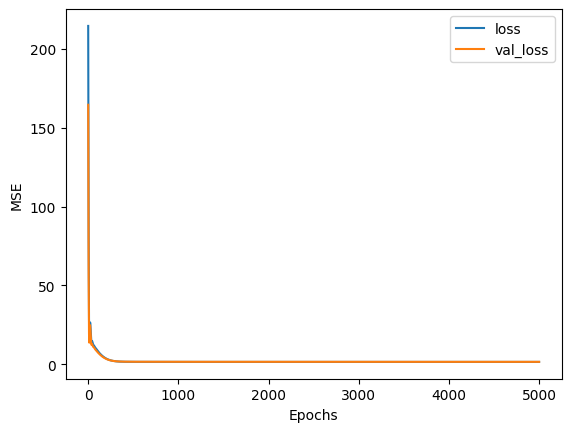

In [10]:
plt.plot(hist_lr.history['loss']) #Note this is the MSE and not the RMSE
plt.plot(hist_lr.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

#### Evaluation of the Performance 


In [11]:
# Calculation of the the optimal sigma on the train set 
y_hat_train = model_lr.predict(X_train)
sigma_hat_2 = (n-1.)/(n-2.) * np.var(y_train - y_hat_train.flatten(), ddof=1)
print('Estimated variance ', sigma_hat_2)
print('Estimated standart deviation ', np.sqrt(sigma_hat_2))

# Prediction on the test set
y_hat = model_lr.predict(X_test)
RMSE_lr = np.sqrt(np.mean((y_test - y_hat.flatten())**2))
MAE_lr = np.mean(np.abs(y_test - y_hat.flatten())) 

NLL_lr =  0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_test - y_hat.flatten())**2)/sigma_hat_2
print('NLL on training:', 0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_train - y_hat_train.flatten())**2)/sigma_hat_2)

df2 = pd.DataFrame(
          {'RMSE' : RMSE_lr, 'MAE' : MAE_lr, 'NLL (mean)' : NLL_lr}, index=['Linear Regression (MSE Keras)']
)
pd.concat([df1,df2])

238/238 [==============================] - 0s 1ms/step
Estimated variance  1.4298408896788797
Estimated standart deviation  1.1957595450921057
57/57 [==============================] - 0s 2ms/step
NLL on training: 1.5975883322340123


,RMSE,MAE,NLL (mean)
Linear Regression (sklearn),1.217305,0.957993,1.615901
Linear Regression (MSE Keras),1.217305,0.957993,1.615901


In the pandas dataframe above you see that the RMSE, MAE and the NLL are somewhat the same. In the next cell you are comparing the coefficients of the keras and sklearn linear regression models. As you can see you get close results! 

In [12]:
print('weights using deep learning:          ', model_lr.get_weights()[0][:,0])
print('weights from sklearn:                 ', res.coef_)
print('Intercept (bias) using deep learning: ', model_lr.get_weights()[1][0])
print('Intercept (bias) using sklearn:       ', res.intercept_)

weights using deep learning:           [0.00545378 0.00030307 0.26146737]
weights from sklearn:                  [0.00545365 0.00030294 0.26146547]
Intercept (bias) using deep learning:  0.8475283
Intercept (bias) using sklearn:        0.8475454175621584


Let's plot the observed values vs the predicted mean of scored goals on the test dataset. To inicate the CPD we also plot the 2.5% and 97.5% percentiles of the predicted CPD.

57/57 [==============================] - 0s 2ms/step


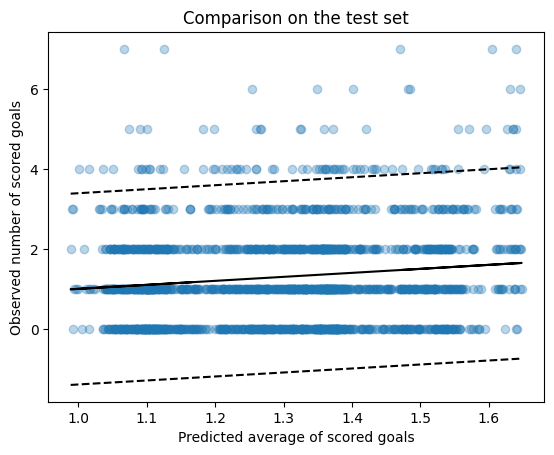

In [13]:
y_hat_test = model_lr.predict(X_test)

plt.scatter(y_hat_test, y_test, alpha=0.3)
sort_idx=np.argsort(y_hat_test, axis=0)
plt.plot(y_hat_test[sort_idx].flatten(), y_hat_test[sort_idx].flatten()+2*np.sqrt(sigma_hat_2), linestyle='dashed', c="black")
plt.plot(y_hat_test[sort_idx].flatten(), y_hat_test[sort_idx].flatten()-2*np.sqrt(sigma_hat_2), linestyle='dashed', c="black")
plt.plot(y_hat_test, y_hat_test, c="black")
plt.title('Comparison on the test set')
plt.xlabel('Predicted average of scored goals')
plt.ylabel('Observed number of scored goals')
plt.show()

Lets check the predicted outcome distribution for the observations 31 and 33.

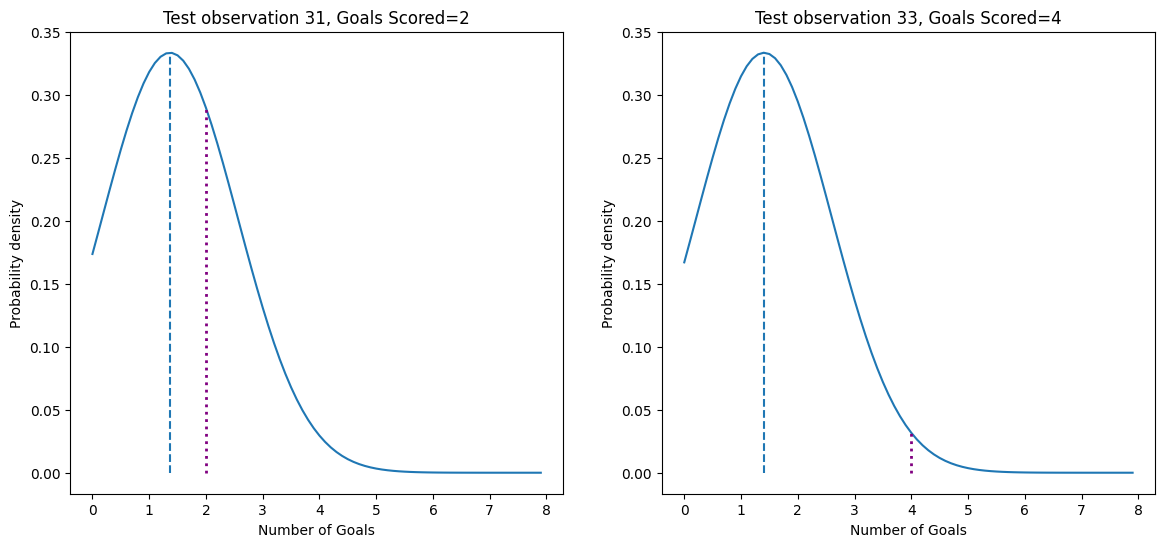

In [14]:
dist = tfd.Normal(loc=y_hat_test, scale=np.sqrt(sigma_hat_2, dtype="float32"))

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(np.arange(0,8,0.1), dist.prob(np.arange(0,8,0.1))[31])
plt.vlines(y_hat_test[31], ymin=0, ymax=dist.prob(y_hat_test)[31], linestyle='dashed')
plt.vlines(np.expand_dims(y_test, axis=1)[31], ymin=0, ymax=dist.prob(np.expand_dims(y_test,axis=1))[31], linestyle='dotted', color="purple", linewidth=2)
plt.xlabel('Number of Goals')
plt.ylabel('Probability density')
plt.title(f'Test observation 31, Goals={int(y_test[31])}')

plt.subplot(1,2,2)
plt.plot(np.arange(0,8,0.1),dist.prob(np.arange(0,8,0.1))[33])
plt.vlines(y_hat_test[33], ymin=0, ymax=dist.prob(y_hat_test)[33],linestyle='dashed')
plt.vlines(np.expand_dims(y_test,axis=1)[33], ymin=0, ymax=dist.prob(np.expand_dims(y_test,axis=1))[33], linestyle='dotted', color="purple", linewidth=2)
plt.xlabel('Number of Goals')
plt.ylabel('Probability density')
plt.title(f'Test observation 33, Goals={int(y_test[33])}')

plt.show()

You can see that the liklihood of the observed values are quite high under the predicted CPDs (dotted line) but it fails to foresee stomps. However, note that the linear model predicts also negative values, which is obviously wrong. 

## Poisson Regression 

Now we will use the TFP framework and the Poission distribution to model the output of the network as a Poissonian CPD. We will not use any hidden layers in between and the loss will be the NLL. After the fitting, we predict the test data and compare the performance with the linear regression model.
$$
    Y \thicksim \tt{Pois}(exp(w^{T} \cdot x + b))
$$

In [15]:
inputs = Input(shape=(X_train.shape[1],))  
rate = Dense(1, activation=tf.exp)(inputs) #A
p_y = tfp.layers.DistributionLambda(tfd.Poisson)(rate) #B 
model_p = Model(inputs=inputs, outputs=p_y) #C


def NLL(y_true, y_hat): #D
  return -y_hat.log_prob(y_true)

model_p.compile(Adam(learning_rate=0.01), loss=NLL)
model_p.summary()

#A Definition of a single layer with one output
#B We use exponential of the output to model the rate
#C Glueing the NN and the output layer together. Note that output p_y is a tf.distribution
#D The second argument is the output of the model and thus a tfp-distribution. It's as simple as calling log_prob to calculate the log-probability of the observation that is needed to calculate the NLL.

Instructions for updating:
The `interpolate_nondiscrete` flag is deprecated; instead use `force_probs_to_zero_outside_support` (with the opposite sense).
Instructions for updating:
The `interpolate_nondiscrete` property is deprecated; instead use `force_probs_to_zero_outside_support` (with the opposite sense).
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
 distribution_lambda (Distri  ((None, 1),              0         
 butionLambda)                (None, 1))                         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
___________________

In [16]:
hist_p = model_p.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=2000, verbose=0)

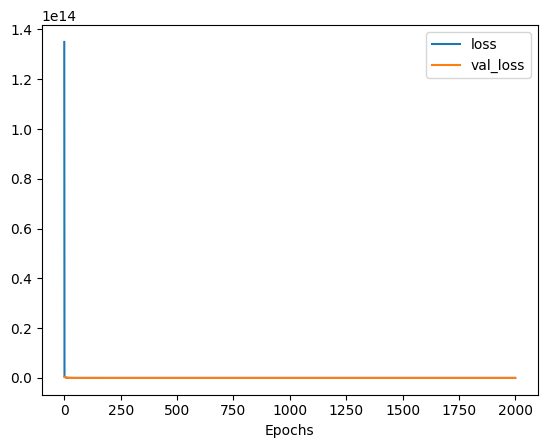

In [17]:
plt.plot(hist_p.history['loss'])
plt.plot(hist_p.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epochs')
plt.show()

#### Evaluation of the Performance 


In [18]:
model = Model(inputs=inputs, outputs=p_y)

# Prediction on the test set
y_hat_test = model.predict(X_test).flatten()

rmse=np.sqrt(np.mean((y_test - y_hat_test)**2))
mae=np.mean(np.abs(y_test - y_hat_test)) 

NLL = model_p.evaluate(X_test, y_test)

df3 = pd.DataFrame(
         { 'RMSE' : rmse, 'MAE' : mae, 'NLL (mean)' : NLL}, index=['Poisson Regression (TFP)']
)
pd.concat([df1, df2, df3])

57/57 [==============================] - 0s 1ms/step - loss: 1.5003


,RMSE,MAE,NLL (mean)
Linear Regression (sklearn),1.217305,0.957993,1.615901
Linear Regression (MSE Keras),1.217305,0.957993,1.615901
Poisson Regression (TFP),1.621385,1.214444,1.500326


Let's plot the observed values vs the predicted mean of caught fish on the test dataset. To inicate the CPD you also plot  the 2.5% and 97.5% percentiles of the predicted CPD. You highlight the observations 31 and 33.

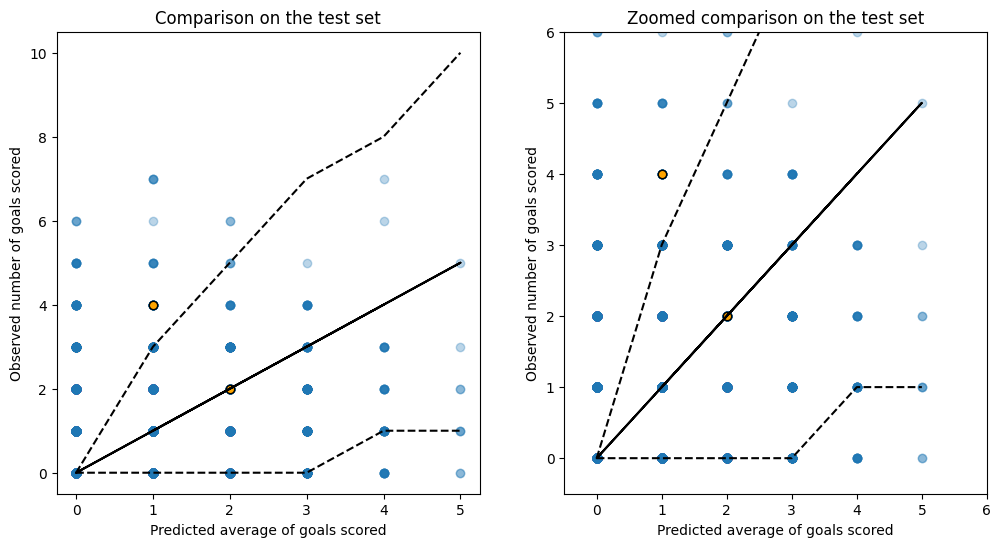

In [19]:
from scipy.stats import poisson

lower=poisson.ppf(0.025, y_hat_test)
upper=poisson.ppf(0.975, y_hat_test)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.scatter(y_hat_test[33], y_test[33], c="orange", marker='o', edgecolors="black")
plt.scatter(y_hat_test[31], y_test[31], c="orange", marker='o', edgecolors="black")
plt.title('Comparison on the test set')
plt.xlabel('Predicted average of goals scored')
plt.ylabel('Observed number of goals scored')
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), lower[np.argsort(y_hat_test,axis=0)], linestyle='dashed', c="black")
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), upper[np.argsort(y_hat_test,axis=0)], linestyle='dashed', c="black")
plt.plot(y_hat_test, y_hat_test, c="black")


plt.subplot(1,2,2)
plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.scatter(y_hat_test[33], y_test[33], c="orange", marker='o', edgecolors="black")
plt.scatter(y_hat_test[31], y_test[31], c="orange", marker='o', edgecolors="black")
plt.title('Zoomed comparison on the test set')
plt.xlabel('Predicted average of goals scored')
plt.ylabel('Observed number of goals scored')
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), lower[np.argsort(y_hat_test,axis=0)], linestyle='dashed', c="black")
plt.plot(y_hat_test[np.argsort(y_hat_test,axis=0)].flatten(), upper[np.argsort(y_hat_test,axis=0)], linestyle='dashed', c="black")
plt.plot(y_hat_test, y_hat_test, c="black")
plt.xlim([-0.5,6])
plt.ylim([-0.5,6])

plt.show()

Lets check the predicted outcome distribution for the observations 31 and 33.

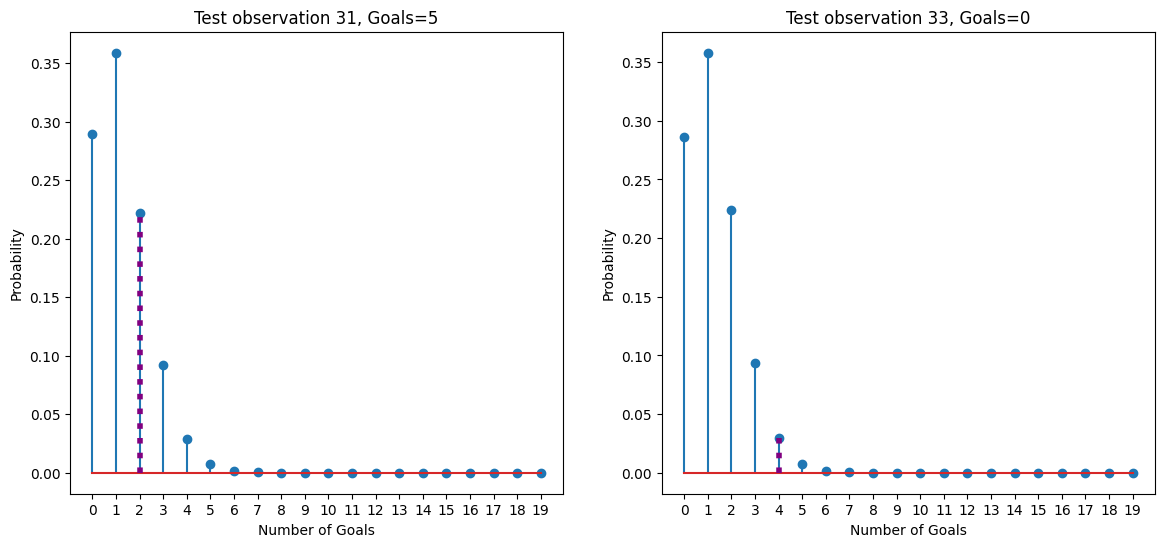

In [20]:
probs=model_p(X_test.values).tensor_distribution.prob(np.arange(0,20,1)).numpy()

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.stem(np.arange(0,20,1), probs[31,:])
plt.xticks(np.arange(0,20,1))
plt.vlines(np.expand_dims(y_test, axis=1)[31], ymin=0, ymax=probs[31, int(y_test[31])], linestyle='dotted', color="purple", linewidth=4)
plt.xlabel('Number of Goals')
plt.ylabel('Probability')
plt.title(f'Test observation 31, Goals={int(y_test[31])}')

plt.subplot(1,2,2)
plt.stem(np.arange(0,20,1), probs[33,:])
plt.xticks(np.arange(0,20,1))
plt.vlines(np.expand_dims(y_test, axis=1)[33], ymin=0, ymax=probs[33, int(y_test[33])], linestyle='dotted', color="purple", linewidth=4)
plt.xlabel('Number of Goals')
plt.ylabel('Probability')
plt.title(f'Test observation 33, Goals={int(y_test[33])}')

plt.show()

## Zero inflated Poisson Regression 

We will now define a model with two outputs, one for the poisson mean and one for the probability that zero fish were caught. This is the so called zero-inflated Poisson distribution. We use the TFP framework to create a mixture two processes: a Poission process and a zero generating process. We will not use any hidden layers in between and the loss will be the NLL. After the fitting, we predict the test data and compare the performance with the other models.

The ZIP distribution needs two parameters:
* rate: which defines the rate $\lambda$ of a Poisson process
* s: the probability to pick Poisson process (accordingly the zero-generating process is picked with probability 1-s)

#### Custom Distribution for a zero inflated Poisson distribution

In [21]:
def zero_inf(out): 
    rate = tf.squeeze(tf.math.exp(out[:, 0:1])) #A 
    s = tf.math.sigmoid(out[:, 1:2]) #B  
    probs = tf.concat([1-s, s], axis=1) #C 
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#D
          components=[
          tfd.Deterministic(loc=tf.zeros_like(rate)), #E
          tfd.Poisson(rate=rate), #F 
        ])

#A The first component codes for the rate. We used exponential to guaranty values > 0. We also used the squeeze function to flatten the tensor.
#B The second component codes for zero inflation; using the sigmoid squeezes the value between 0 and 1.
#C The two probabilities for 0’s or Poissonian distribution 
#D tfd.Categorical allows creating a mixture of two components. 
#E Zero as a deterministic value 
#F Value drawn from a Poissonian distribution

In the next cell you can check if the ZIP distribution is working. As you can see in the code above, the zero_inf distribution takes two values as input. The first value controls the rate of the Poisson distribution and the second value controls the probability to pick the Poisson process. Both values can be negative or positive. To guarantee that the rate is a positive number, we transform the first argument with the exp() function.To guarantee that the probability s is a number between zero and one, we transform the second argument with the sigmoid() function.  

If the first argument is 1 then the rate of the Poisson process is exp(1) ~ 2.7. If the second argument is 10 then the probability to pick the Poisson process is sigmoid(10) ~ 0.9999. Accordingly, if the input to the zero_inf() distribution is 1 and 10, we would expect that we almost always take the Poisson process which has a rate parameter of ~ 2.7.  

If the input to the zero_inf() distribution is 1 and -10, we would expect that we almost always pick the zero-generating process. 
  
In the following cell you can check that the zero_inf function works as expected. It is also possible to sample from the distribution or calculate the mean.

In [22]:
## testing the distribution, we evalute some data 
print("rate of the poissonian :", tf.exp(1.0).numpy())
print("probability to pick the poisson process :", tf.math.sigmoid(10.0).numpy())
print("probability to pick the poisson process :", tf.math.sigmoid(-10.0).numpy())

t = np.ones((2,2), dtype=np.float32)
t[0,0] = 1
t[0,1] = 10 #almost always take pois 
t[1,0] = 1
t[1,1] = -10 # almost always take zero

print('Input Tensor : ')
print(t)
print('Output Mean  : ', zero_inf(t).mean().numpy())
print('Output Sample  : ', zero_inf(t).sample().numpy())

rate of the poissonian : 2.7182817
probability to pick the poisson process : 0.9999546
probability to pick the poisson process : 4.539787e-05
Input Tensor : 
[[  1.  10.]
 [  1. -10.]]
Output Mean  :  [2.7181582e+00 1.2340420e-04]
Output Sample  :  [3. 0.]


#### NN in front of a zero inflated Poisson distribution

In [23]:
# Definition of the custom parametrized distribution
inputs = tf.keras.layers.Input(shape=(X_train.shape[1],))  
out = Dense(2)(inputs)
p_y_zi = tfp.layers.DistributionLambda(zero_inf)(out)
model_zi = Model(inputs=inputs, outputs=p_y_zi)

#A A dense layer is used without activation. The transformation is done inside the zero_inf function
model_zi.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 8         
                                                                 
 distribution_lambda_1 (Dist  (None, None)             0         
 ributionLambda)                                                 
                                                                 
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


### Training of the model (by hand)with GradientTape [optional]

The following code trains the NN using a evaluation loop by hand. This can help to find instabilities, See also: https://www.tensorflow.org/beta/guide/keras/training_and_evaluation#part_ii_writing_your_own_training_evaluation_loops_from_scratch


In [24]:
# model_zi = Model(inputs=inputs, outputs=p_y_zi)

# optimizer=tf.optimizers.Adam(learning_rate=0.05)
# steps=10
# loss_values = np.zeros((steps))
# for e in range(steps):
#     with tf.GradientTape() as tape:
#         y_hat = model_zi(X_train.values)
#         loss_value = -tf.reduce_mean(y_hat.log_prob(y_train))
#         loss_values[e] = loss_value
#         grads = tape.gradient(loss_value, model_zi.trainable_weights)
#         weights =  model_zi.trainable_weights       
#         optimizer.apply_gradients(zip(grads, weights))
#         print(loss_value)

### Training using keras

In [25]:
def NLL(y_true, y_hat):
    return -y_hat.log_prob(tf.reshape(y_true, (-1,)))

model_zi.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=NLL)

In [26]:
model = Model(inputs=inputs, outputs=p_y_zi) 

# Prediction on the test set
y_hat_test = model.predict(X_test.values).flatten()

mse=np.sqrt(np.mean((y_test - y_hat_test)**2))
mae=np.mean(np.abs(y_test - y_hat_test)) 

NLL = model_zi.evaluate(X_test.values, y_test)

df4 = pd.DataFrame(
         { 'RMSE' : mse, 'MAE' : mae, 'NLL (mean)' : NLL}, index=['ZIP (TFP)']
)
pd.concat([df1, df2, df3, df4])

57/57 [==============================] - 0s 1ms/step - loss: 359520751591620608.0000


,RMSE,MAE,NLL (mean)
Linear Regression (sklearn),1.217305e+00,9.579933e-01,1.615901e+00
Linear Regression (MSE Keras),1.217305e+00,9.579927e-01,1.615901e+00
Poisson Regression (TFP),1.621385e+00,1.214444e+00,1.500326e+00
ZIP (TFP),4.306587e+18,3.595208e+17,3.595208e+17


In [27]:
hist_zi = model_zi.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=2000, verbose=0)

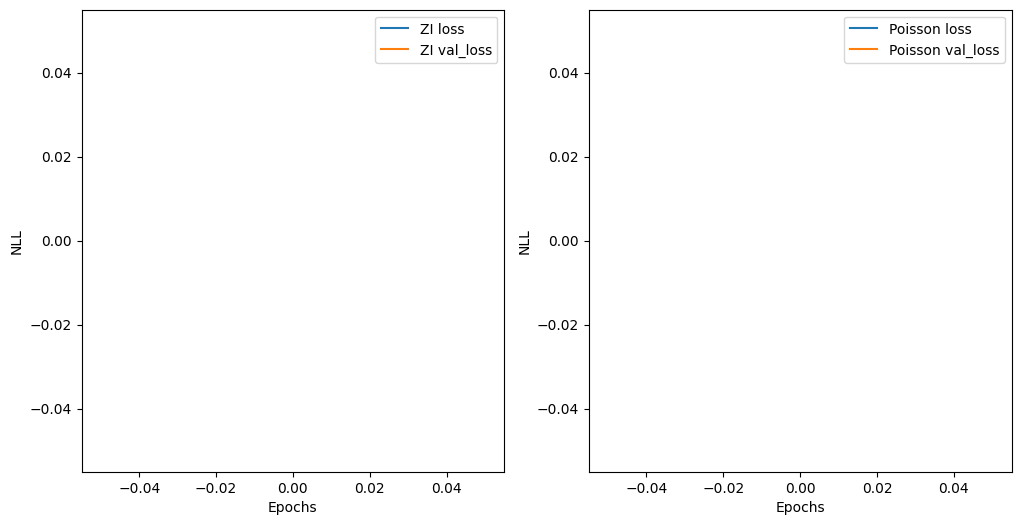

In [28]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(hist_zi.history['loss'])
plt.plot(hist_zi.history['val_loss'])
plt.legend(['ZI loss', 'ZI val_loss'])
plt.xlabel('Epochs')
plt.ylabel('NLL')

plt.subplot(1,2,2)
# plt.plot(hist_p.history['loss'], linestyle='-.')
# plt.plot(hist_p.history['val_loss'])
plt.plot(hist_zi.history['loss'])
plt.plot(hist_zi.history['val_loss'])
plt.legend(['Poisson loss', 'Poisson val_loss', 'ZI loss', 'ZI val_loss'])
plt.xlabel('Epochs')
plt.ylabel('NLL')

plt.show()

#### Evaluation of the Performance 


In [29]:
model = Model(inputs=inputs, outputs=p_y_zi) 

# Prediction on the test set
y_hat_test = model.predict(X_test.values).flatten()

mse=np.sqrt(np.mean((y_test - y_hat_test)**2))
mae=np.mean(np.abs(y_test - y_hat_test)) 

NLL = model_zi.evaluate(X_test.values, y_test)

df4 = pd.DataFrame(
         { 'RMSE' : mse, 'MAE' : mae, 'NLL (mean)' : NLL}, index=['ZIP (TFP)']
)
pd.concat([df1, df2, df3, df4])

In the pandas dataframe above you see that the RMSE, MAE and the NLL of the diferent models. You see that the ZIP regression outperforms the Poisson and the Linear regression models  because of the lower NLL.

Let's plot the observed values vs the predicted mean of caught fish on the test dataset. To inicate the CPD you also plot  the 2.5% and 97.5% percentiles of the predicted CPD. You highlight the observations 31 and 33.

In [ ]:
samples=model_zi(X_test.values).sample(5000).numpy()

lower = np.quantile(samples, 0.025, axis=0)
upper = np.quantile(samples, 0.975, axis=0)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.scatter(y_hat_test[33], y_test[33], c="orange", marker='o', edgecolors="black")
plt.scatter(y_hat_test[31], y_test[31], c="orange", marker='o', edgecolors="black")
plt.title('Comparison on the test set')
plt.xlabel('Predicted average of goals scored')
plt.ylabel('Observed number of goals scored')
plt.plot(y_hat_test[np.argsort(y_hat_test, axis=0)].flatten(), lower[np.argsort(y_hat_test, axis=0)], linestyle='dashed', c="black")
plt.plot(y_hat_test[np.argsort(y_hat_test, axis=0)].flatten(), upper[np.argsort(y_hat_test, axis=0)], linestyle='dashed', c="black")
plt.plot(y_hat_test, y_hat_test, c="black")

plt.subplot(1,2,2)
plt.scatter(y_hat_test, y_test, alpha=0.3)
plt.scatter(y_hat_test[33], y_test[33], c="orange", marker='o', edgecolors="black")
plt.scatter(y_hat_test[31], y_test[31], c="orange", marker='o', edgecolors="black")
plt.title('Zoomed comparison on the test set')
plt.xlabel('Predicted average of goals scored')
plt.ylabel('Observed number of goals scored')
plt.plot(y_hat_test[np.argsort(y_hat_test, axis=0)].flatten(), lower[np.argsort(y_hat_test, axis=0)], linestyle='dashed', c="black")
plt.plot(y_hat_test[np.argsort(y_hat_test, axis=0)].flatten(), upper[np.argsort(y_hat_test, axis=0)], linestyle='dashed', c="black")
plt.plot(y_hat_test, y_hat_test, c="black")
plt.xlim([-0.5,6])
plt.ylim([-0.5,6])

plt.show()

Compared to the Poisson model it is striking that the 2.5% percentile is zero over the whole range. This is due the zero-inflated process modeling a higher amount of zeros compared to the Poisson process.

Lets check the predicted outcome distribution for the observations 31 and 33.

In [ ]:
probs=model_zi(X_test.values).tensor_distribution.prob(np.arange(0,20,1).reshape(20,1)).numpy()

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.stem(np.arange(0,20,1), probs[:,31])
plt.vlines(np.expand_dims(y_test,axis=1)[31], ymin=0, ymax=probs[int(y_test[31]), 31], linestyle='dotted', color="purple", linewidth=4)
plt.xticks(np.arange(0,20,1))
plt.xlabel('Number of Goals')
plt.ylabel('Probability')
plt.title(f'Test observation 31, Goals={int(y_test[31])}')

plt.subplot(1,2,2)
plt.stem(np.arange(0,20,1), probs[:,33])
plt.vlines(np.expand_dims(y_test,axis=1)[33], ymin=0, ymax=probs[int(y_test[33]), 33], linestyle='dotted', color="purple", linewidth=4)
plt.xticks(np.arange(0,20,1))
plt.xlabel('Number of Events')
plt.ylabel('Probability')
plt.title(f'Test observation 33, Goals={int(y_test[33])}')

plt.show()

You can see that the  predicted CPDs has a large peak at zero. This is due the zero-inflated process modeling a higher amount of zeros compared to the Poisson process.  
You can see that the liklihood of the observed values are quite high under the predicted CPDs (dotted line). Note that the ZIP CPD does only predict non-negative integer values which is a quite nice property for count data.
